# PROJECT: Course Optimization for Data Science 2021-2022
## Optimization strategies for the multiclass multinomial logistic regression with non-smooth penalties


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the multinomial logistic regression model
- Implement your own solvers for L1, L2 and L1/L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for the multinomial logistic regression model and test it on the `digits` dataset.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 4th of March 2022 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "pierre"
ln1 = "ablin"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_ablin_pierre_and_gramfort_alexandre.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 0: Multinomial logistic regression model

This model is a multinomial logistic regression model. It is a supervised learning model, in the case where the target space $\mathcal{Y}$ is discrete: $\mathcal{Y}=\{1, \dots, K\}$; this is a multiclass classification model.

We consider a sample $x \in \mathbb{R}^{P}$ belonging to $K$ possible classes.

We want to solve the classification task, _i.e.,_ learn the parameters $\theta = (\mathbf{W}, \mathbf{b}) \in \mathbb{R}^{P\times K}\times \mathbb{R}^{K}$ of the function $f_\theta: \mathbb{R}^P \to [0, 1]^K$ which corresponds for each coordinate to the probability of being from one class.

The model is defined as
$$
[f_\theta(x)]_k = \mathbb{P}[Y=k | x] = \frac{1}{Z} \exp(w_k^\top x + b_k) \enspace ,
$$
where $w_k$ corresponds to the kth column of $W$, and $Z$ is a normalizing constant.

As these probabilities must sum to one, we get
$$
Z = \sum_{k=1}^K \exp(w_k^\top x + b_k).
$$
We can recognize the so-called _soft-max_ function: $[\sigma(z)]_i = \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}$.

After one-hot encoding of the target variable ([`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), denoting $\{ y_{ik} \}_{k=1}^{K}$ the indicator sequence for the class of the $i^{\text{th}}$ observation $x_i$ (i.e., if the sample $i$ belongs to class $k$, then $y_{ik} = 1$ and $y_{ik'}=0$ for $k'\neq k$) the negative log likelihood (**nll**, _a.k.a_ cross-enropy loss) becomes:
$$
L(W, b) = - \frac1N \sum_{i=1}^N \log(\mathbb{P}[Y=y_i | x_i]) = -\frac1N \sum_{i=1}^N \log\Bigg(\frac{\exp(w_{y_i}^\top x_i + b_{y_i})}{\sum_{k=1}^K \exp(w_k^\top x_i+ b_k)}\Bigg) \enspace .
$$

**Note:** The notation $w_{y_i}$ means the column of $W$ whose index corresponds to the class value (e.g. 1, 2, ..., K) for the sample $x_i$.

Using the softmax function, we can also rewrite this as
$$
L(W, b) =  -\frac1N \sum_{i=1}^N \log([\sigma(Wx_i + b)]_{y_i})
$$

Introducing some regularization on the parameter $W$ with parameter $\lambda \ge 0$, the penalized likelihood estimation problem is written:

$$
    (\mathcal{P}):
	\min_{W, b} \quad L(W, b) + \lambda \mathcal{R}(W)
$$

where $\mathcal{R}(W)$ can be :
- $\mathcal{R}_1(W) = \|W\|_1 = \sum_{j=1}^P \sum_{k=1}^K |W_{jk}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(W) = \tfrac{1}{2} \|W\|^2_F = \tfrac{1}{2} \sum_{j=1}^P \sum_{k=1}^K W_{jk}^2$, ie. a squared $\ell_2$ norm 
- $\mathcal{R}_{21}(W) = \|W\|_{21} = \sum_{j=1}^P \sqrt{\sum_{k=1}^K W_{jk}^2}$, ie. an $\ell_{21}$ mixed-norm. This corresponds to the $\ell_1$ norm of the sequence of $\ell_2$ norms of the rows of $W$.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that $(\mathcal{P})$ is a convex problem for the 3 different choices of regularization.</li>
    </ul>
</div>

**Hint**: You can show that for $z\in\mathbb{R}^K$ and $1\leq j\leq K$, the function $z\to -\log(\sigma(z)_j)$ is convex.

INSERT YOUR ANSWER HERE

## Simulation

Let's first generate data under the above model, with $K=3$ classes.

In [3]:
from sklearn.preprocessing import OneHotEncoder

def plot_data(X, y, U=None, ax=None):
    if y.ndim == 1:
        y = OneHotEncoder().fit_transform(y[:, None]).toarray()
    n_classes = y.shape[1]
    class_colors = plt.get_cmap('viridis', n_classes)(range(n_classes))
    # Display the result in ax, which is created if it does not exist.
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(X[:, 0], X[:, 1], c=y @ class_colors)

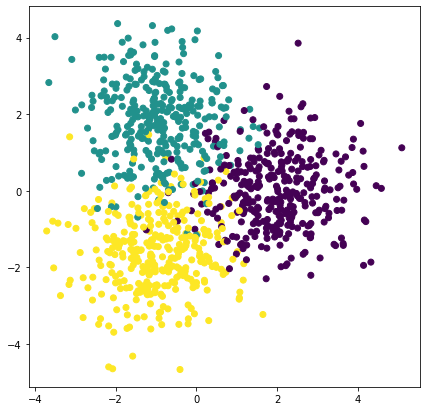

In [4]:
from sklearn.datasets import make_blobs

MU1 = (2, 0)
MU2 = (-1, np.sqrt(3))
MU3 = (-1, -np.sqrt(3))

centers = [MU1, MU2, MU3]
K = len(centers)  # number of classes
N = 1000

X, y_true = make_blobs(N, centers=centers, random_state=42)

plot_data(X, y_true)

In [5]:
# One-hot encoded target
Y = OneHotEncoder().fit_transform(y_true[:, None]).toarray()
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Given some random values for $W$ and $b$, we want to compute the quantity $P(Y = k \mid x_i)$ for $k= 1, \dots , K$, and $i= 1, \dots, n$.

Note that in order to predict the label of $x$, we take the arg-maximum of the softmax values.

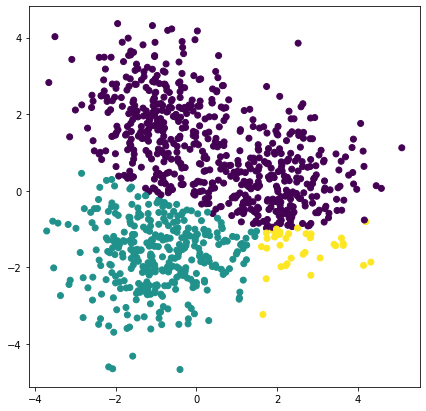

In [6]:
from scipy.special import softmax

rng = np.random.RandomState(42)
P = 2
W = rng.randn(P, K)
b = rng.randn(K)
y_proba_ = softmax(X @ W + b, axis=1)
y_ = np.argmax(y_proba_, axis=1)

plot_data(X, y_)

Note, that the sum of all probabilites for each sample is 1:

In [7]:
np.testing.assert_allclose(np.sum(y_proba_, axis=1), np.ones(N))

# Log-Likelihood function

Following the parametrization from $(\mathcal{P})$, one has `K + K*P` parameters.
We denote the stacked vector of all parameters `params`. The first `K` entries in `params` are the b and the last `K*P` entries correspond to $W$. The function that predicts the probabilities of each sample reads:

In [8]:
def predict_proba(params, X=X):
    """Compute the probability of each sample in X.
    
    Parameters:
    -----------
    params: array, shape (K + K * P,)
        Parameters of the model. The first K entries are the beta_k,
        the remaining K * P ones are the entries of W.

    X: array, shape (N, P)
        The features.

    Returns
    -------
    proba : ndarray, shape (N, K)
        The proba of belonging to each class for each sample.
    """
    _, P = X.shape
    K = params.size // (1 + P)
    b = params[:K]
    W = params[K:].reshape(P, K)
    return softmax(X @ W + b, axis=1)

The negative log-likelihood then reads:

In [9]:
def negloglik(params, X=X, Y=Y):
    Y_proba = predict_proba(params, X)
    loss = -np.log(Y_proba[Y == 1]).mean()
    return loss

params = np.concatenate([b, W.ravel()])
negloglik(params)

2.138083050969259

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>Can you apply coordinate descent or proximal gradient descent to 
  $(\mathcal{P})$ ? Justify your answer with mathematical arguments and theoretical results from the course. No coding yet!</li>
    </ul>
</div>

INSERT YOUR ANSWER HERE

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
      <li>Propose solutions for the proximal operators for the 2 regularization functions: 
  $\mathcal{R}_1(W)$ and $\mathcal{R}_2(W)$.</li>
    </ul>
</div>

**Proximal operator of $\mathcal{R}_1(W)$ :**
$$
\text{prox}_{\mathcal{R}_1}(v) = \text{ argmin}_x \frac12 \|x-v\|_2^2 + λ\|x\|_1
$$

Then, we have the following optimality condition :
$$
0 \in ∂(\frac12 \|x-v\|_2^2 + λ\|x\|_1) = x - v + λ\partial(\|x\|_1)
$$



**Proximal operator of $\mathcal{R}_2(W)$ :** 
 $$
\text{prox}_{\mathcal{R}_2}(v) = \text{ argmin}_x \frac12 \|x-v\|_2^2 + \fracλ2\|x\|_2^2
$$

Taking gradient, we have the following optimality condition :
$$
x(λ + 1) - v = 0 ↔ x^* = \frac{v}{(1+λ)}
$$

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Justify that the prox for the regularization function 
  $\mathcal{R}_{21}(W)$ is written:
$$
\mathrm{prox}_{\lambda R_{21}} (W) = Z \in \mathbb{R}^{P \times K} \quad \mathrm{where} \quad Z_{i, :} =\left(1 − \frac{\lambda}{\max(\|W_{i,:}\|_2, \lambda)}\right) W_{i, :}  \enspace .
$$
         </li>
    </ul>
</div>

The notation $W_{i, :} \in \mathbb{R}^K$ stands for the ith row of $W$.

Alternatively, we can write this as

$$
Z_{i, :} = \begin{cases} 0 \text{ if } \|W_{i, :}\|_2\leq \lambda \\
(\|W_{i, :}\|_2 - \lambda)\frac{W_{i, :}}{\|W_{i, :}\|_2} \text{ otherwise}
\end{cases}
$$

**HINT:** This proximal operator is called a block thresholding. You can check that the prox for $\mathcal{R}_{21}(W)$ and $\mathcal{R}_{1}(W)$ match with $K=1$.

INSERT YOUR ANSWER HERE

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Implement below the proximal operators for the 3 regularization functions: 
  $\mathcal{R}_1(W)$, $\mathcal{R}_2(W)$ and $\mathcal{R}_{21}(W)$.</li>
    </ul>
</div>

(-1.0, 3.0)

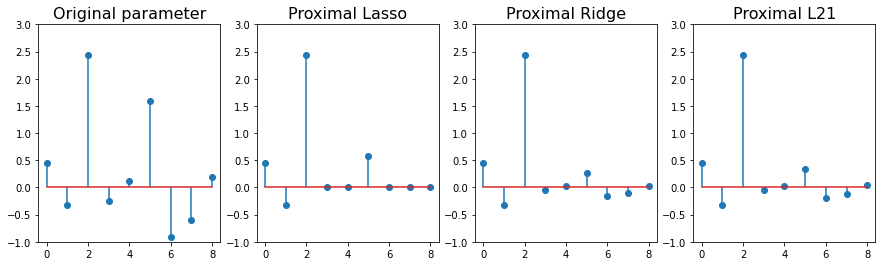

In [10]:
def prox_R2(params, reg=1., K=K):
    """Prox for R2 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)

    Z = W / (reg + 1)

    return np.hstack((b,Z.flatten()))


def prox_R1(params, reg=1., K=K):
    """Prox for R1 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)

    Z = np.sign(W) * np.maximum(np.abs(W) - reg, 0.)

    return np.hstack((b,Z.flatten()))

def prox_R21(params, reg=1., K=K):
    """Prox for R21 regularizer"""
    params = params.copy()
    b = params[:K]
    W = params[K:].reshape(-1, K)

    Z = W * (1 - reg/(np.maximum(linalg.norm(W, ord=2), reg)))

    return np.hstack((b,Z.flatten()))


rng = np.random.RandomState(5)
params = rng.randn((P + 1) * K)
l_l1 = 1.
l_l2 = 5.
l_l21 = 1.3
ylim = [-1, 3]

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 4, 1)
plt.stem(params, use_line_collection=True)
plt.title("Original parameter", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 2)
plt.stem(prox_R1(params, l_l1), use_line_collection=True)
plt.title("Proximal Lasso", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 3)
plt.stem(prox_R2(params, l_l2), use_line_collection=True)
plt.title("Proximal Ridge", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 4, 4)
plt.stem(prox_R21(params, l_l21), use_line_collection=True)
plt.title("Proximal L21", fontsize=16)
plt.ylim(ylim)

**Note:** You see that the proximal operator does not affect the first 3 entries which correspond to the variable `b` which is not regularized.

## Part 1: Implementation of the solvers

### L-BFGS-B Solver

We will start by using the L-BFGS solver provided by `scipy`. To do this you will first propose a mathematical expression for the gradient of the cross-entropy loss (as implement in the `negloglik` function).

<div class="alert alert-success">
    <b>QUESTION 6:</b>
    <ul>
    <li>
        Propose an expression of the gradients of the loss 
  $L(W, b)$ with respect to its two parameters:
  $\nabla_W L(W, b) \in \mathbb{R}^{P \times K}$ and $\nabla_b L(W, b) \in \mathbb{R}^{K}$.
    </li>
    </ul>
</div>

Let $σ_{y_i}(Wx_i + b)$ be the softmax function applied to sample $i$ from class $y_i$. 

Let's firt derive the softmax function :

$$
∇_{b_k}σ_{y_i}(W,b) = \begin{cases} σ_k(W,b)(1 - σ_k(W,b)) \text{ if } y_i = k \\ -σ_k(W,b)σ_{y_i}(W,b) \text{ for every } k \not= y_i
\end{cases}
$$

In the same way we can say :

$$
∇_{W_k}σ_{y_i}(W,b) = x_i ∇_{b_k}σ(W,b)
$$

Then, taking the $log$ and apply the mean over all samples :    

$$
∇_{W_k}L(W,b) = -\frac1N \sum_{i=1}^N x_i (Y_{i,k} - σ_k(W,b))
$$
$$
∇_{b_k}L(W,b) = -\frac1N \sum_{i=1}^N Y_{i,k} - σ_k(W,b)
$$

Where $Y_i \in \mathbb{R}^K$ is the one hot encoded vector which corresponds to sample $i$.

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the `negloglik_and_grad` function that returns the loss and its gradient.
    </li>
    </ul>
</div>

In [11]:
def negloglik_and_grad(params, X=X, Y=Y):
    """Negative Log-likelihood of the logistic regression model and gradient.

    Parameters
    ----------
    params: array, shape (K + K * P,)
        The parameters.
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.

    Returns
    -------
    loss : float
        log-likelihood of the logreg model
    grad : array, shape (K + K * P,)
        gradient of the model parameters
    """
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)
    #####################
    proba = softmax(X @ W + b, axis=1)
    loss = -np.mean(np.log(proba[Y == 1]))

    log_softmax_deriv = Y - proba

    grad_b = -np.mean(log_softmax_deriv, axis=0)

    grad_w = np.zeros((X.shape[0], P, K))
    for i, sample in enumerate(X):
      for k in range(K):
        grad_w[i,:,k] = sample * log_softmax_deriv[i,k]
    
    grad_w = -np.mean(grad_w, axis=0)
    grad = np.hstack((grad_b, grad_w.flatten()))
    #####################
    return loss, grad

In [12]:
def grad_negloglik(params, X=X, Y=Y):
  return negloglik_and_grad(params, X, Y)[1]

You can check your solution with the following code:

In [13]:
from scipy.optimize import check_grad

rng = np.random.RandomState(42)

for _ in range(10):
    x0 = rng.randn((P+1)*K)
    loss1 = negloglik(x0)
    loss2, grad = negloglik_and_grad(x0)
    np.testing.assert_allclose(loss1, loss2)
    grad_error = check_grad(
        lambda x: negloglik_and_grad(x)[0],
        lambda x: negloglik_and_grad(x)[1],
        x0=x0
    )
    assert grad_error < 1e-6

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Solve the optimization using the `fmin_l_bfgs_b` function without any regularization.
    </li>
    </ul>
</div>

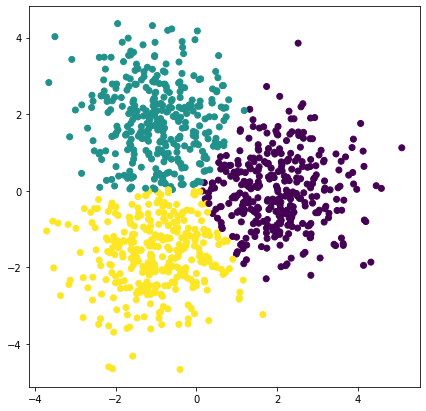

In [14]:
from scipy.optimize import fmin_l_bfgs_b

x0 = np.zeros((P+1)*K)
params_hat = fmin_l_bfgs_b(negloglik_and_grad, x0)[0]

y_proba = predict_proba(params_hat)
plot_data(X, np.argmax(y_proba, axis=1))

In [15]:
!gdown --id 1WfBFw1dyrrPSYJ8HMJTHlHf0QPcsT-7T

zsh:1: command not found: gdown


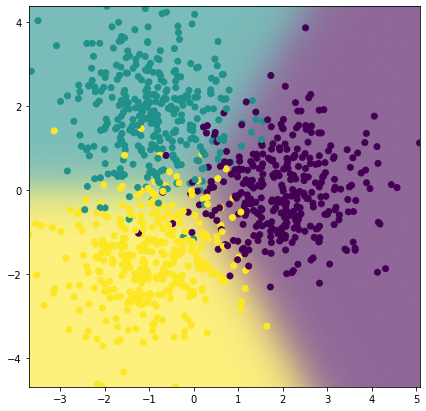

In [16]:
from functools import partial
from utils import show_decision_boundary
show_decision_boundary(partial(predict_proba, params=params_hat), data=(X, Y))

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Wrap this into a function of X, Y and lbda that implements
        the function `multinomial_lbfgs_l2` (Based on 
  $\mathcal{R}_2$ regularization) that will be
        used to get a good value of x_min (minimum of the
  $\ell_2$ regularized
        model).
    </li>
    </ul>
</div>

To help you we give you the code of the objective to minimize
in case you use $\ell_1$, $\ell_2$ and $\ell_{21}$ penalties.

In [17]:
def pobj_l1(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.sum(np.abs(W))


def pobj_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda / 2 * np.linalg.norm(W, 'fro') ** 2


def pobj_l21(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    W = params[K:].reshape(P, K)
    return negloglik(params, X=X, Y=Y) + lbda * np.linalg.norm(W, axis=1).sum()

In [18]:
def grad_l2(params, X=X, Y=Y, lbda=1.):
    K = Y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W_flat = params[K:]
    grad_w_l2 = negloglik_and_grad(params, X, Y)[1][K:] + lbda * W_flat
    grad_b = negloglik_and_grad(params, X, Y)[1][:K]
    return np.hstack((grad_b,grad_w_l2))

def negloglik_and_grad_l2(params, X, Y, lbda=1.):
  negloglik = pobj_l2(params, X, Y, lbda)
  grad = grad_l2(params, X, Y, lbda)
  return negloglik, grad

In [19]:
def multinomial_lbfgs_l2(X, Y, lbda=1):
    """Minimize the pobj_l2 function using L-BFGS
    
    Parameters
    ----------
    X : ndarray, shape (N, P)
        input data.
    Y : ndarray, shape (N, K)
        output targets one-hot encoded.
    lbda : float
        The regularization strength.

    Returns
    -------
    params_hat: array, shape (K + K * P,)
        The estimated parameters.
    """
    K = Y.shape[1]
    P = X.shape[1]
    x_init = np.zeros((K + K * P)) 
    params_hat = fmin_l_bfgs_b(negloglik_and_grad_l2, x_init, args=(X, Y, lbda), pgtol=1e-30)[0]

    return params_hat

multinomial_lbfgs_l2(X, Y, lbda=0.1)

array([-0.03833556, -0.01174344,  0.050079  ,  0.89680299, -0.4338483 ,
       -0.46295469, -0.01243483,  0.7591367 , -0.74670187])

Now that we have a gradient of the negative loglikelihood term we can implement other solvers. Namely you are going to implement:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

**Note:** Below, and following standard optimization notations, we will refer to the parameters of the optimization problem as `x`,  `x_min` and `x_init` for simplicity.

In [20]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(abs(np.array(monit.obj)), lw=2)
        if monit.x_min is not None:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")
        else:
            ax1.set_ylabel("$f(x_k)$")
        ax1.set_xlabel("Epoch")
        ax1.set_title("Objective")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Iterates")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 10a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method
    </li>
    </ul>
</div>

The parameter `step` is the size of the gradient step.

In [21]:
def pgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : ndarray
        Here the params of shape (K + K*P,)
    grad : callable
        The gradient function.
    prox : callable
        The proximal operator function.
    n_iter : int
        The number of iterations
    step : float
        The step size.
    grad_args : tuple
        Extra parameters to pass to the gradient function
        (eg. X, Y)
    prox_args : tuple
        Extra parameters to pass to the prox function
        (eg. lbda, K)
    
    Returns
    -------
    x_hat : ndarray
        The estimated params.
    x_list : list
        The list of iterates values at each iteration.
    """
    x = x_init.copy()
    x_list = []
    #x_list.append(x)
    for i in range(n_iter):
        x = prox(x - step * grad(x, *grad_args), *prox_args)
        x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 10b:</b>
    <ul>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

**Note:** You will have to provide a `step` value, which should be theoretially less than `1 / lipschitz_constant`. You will propose a value for it but you are not expected to provide a mathematical proof, unless you think it's a moral duty to give one...

To help you we give you the proximal operator functions for $\ell_1$, $\ell_2$ and $\ell_{21}$ regularized models.

In [22]:
def prox_l1(params, step, lbda, K):
    return prox_R1(params, reg=step * lbda, K=K)

def prox_l2(params, step, lbda, K):
    return prox_R2(params, reg=step * lbda, K=K)

def prox_l21(params, step, lbda, K):
    return prox_R21(params, reg=step * lbda, K=K)

Let's first consider the $\ell_2$ case. You will use the `multinomial_lbfgs_l2` function to obtain a value for `x_min` so that you can display the convergence error on the iterates (ie. $\|x_k - x^*\|$). You will need to pass this `x_min` to the `monitor` function.

In [23]:
def grad_f(params, X=X, Y=Y):
  return negloglik_and_grad(params, X, Y)[1]

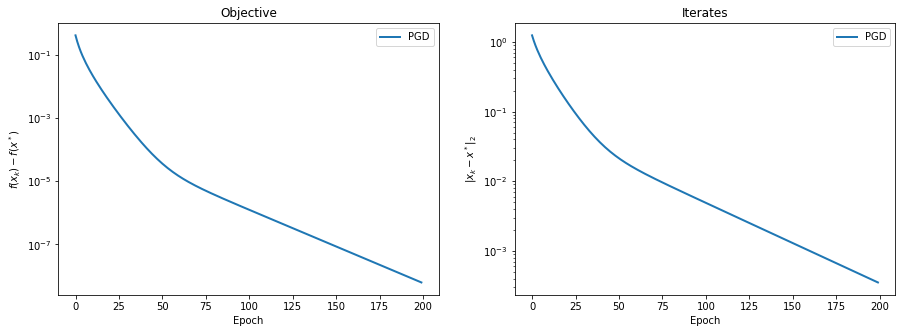

In [24]:
x_init = np.zeros((P + 1) * K)
n_iter = 200
lbda = .1
step = K * N / (linalg.norm(X)**2 * (K-1))

x_min = multinomial_lbfgs_l2(X, Y, lbda)
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, (X, Y, lbda))

grad_args = (X, Y)
prox_args = (step, lbda, K)
monitor_pgd_l2.run(x_init, grad_f, prox_l2, n_iter, step, grad_args, prox_args)

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

In [25]:
x_min

array([-0.03833556, -0.01174344,  0.050079  ,  0.89680299, -0.4338483 ,
       -0.46295469, -0.01243483,  0.7591367 , -0.74670187])


Now for the $\ell_1$ regularization:

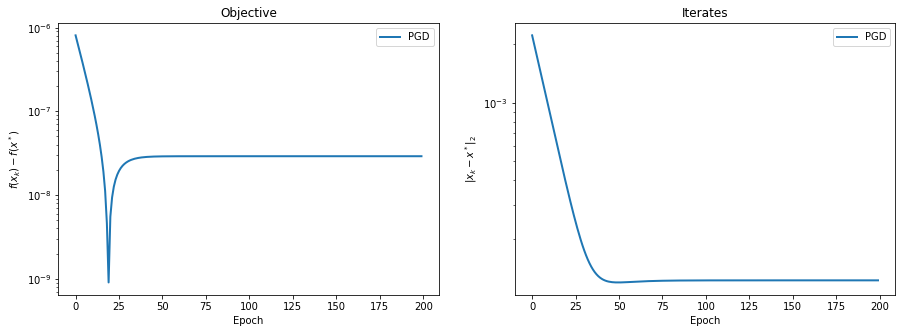

In [26]:
from scipy.optimize import minimize
lbda = 1.

# TODO
x_min = minimize(pobj_l1, x_init, args=(X, Y, lbda), method='SLSQP', 
                 options={'ftol':1e-30}).x
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min, (X, Y, lbda))

grad_args = (X, Y)
prox_args = (step, lbda, K)
monitor_pgd_l1.run(x_init, grad_f, prox_l1, n_iter, step, grad_args, prox_args)
# END TODO

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_{21}$ regularization:

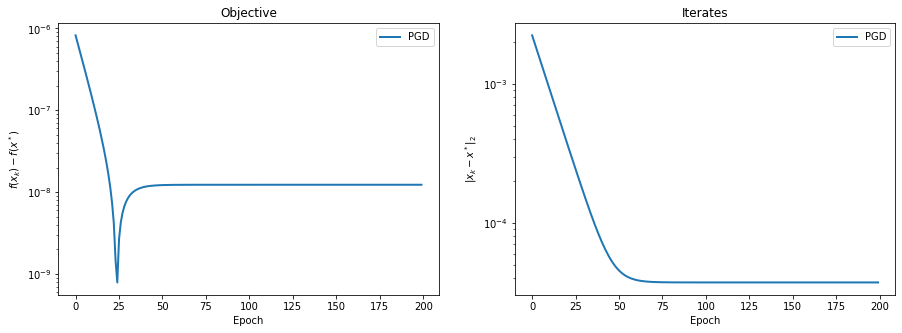

In [27]:
lbda = 1.

# TODO
x_min = minimize(pobj_l21, x_init, args=(X, Y, lbda), method='SLSQP', 
                 options={'ftol':1e-30}).x
monitor_pgd_l21 = monitor(pgd, pobj_l21, x_min, (X, Y, lbda))

grad_args = (X, Y)
prox_args = (step, lbda, K)
monitor_pgd_l21.run(x_init, grad_f, prox_l21, n_iter, step, grad_args, prox_args)
# END TODO

monitors = [monitor_pgd_l21]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [28]:
def apgd(x_init, grad, prox, n_iter=100, step=1., grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = prox(y - step * grad(y, *grad_args), *prox_args)
        t_new = (1 + np.sqrt(1 + 4*t**2)) / 2
        y = x_new + ((t-1) / t_new) * (x_new - x)
        x, t = x_new, t_new
        #################
        ### END TODO
        x_list.append(x.copy())
    return x, x_list

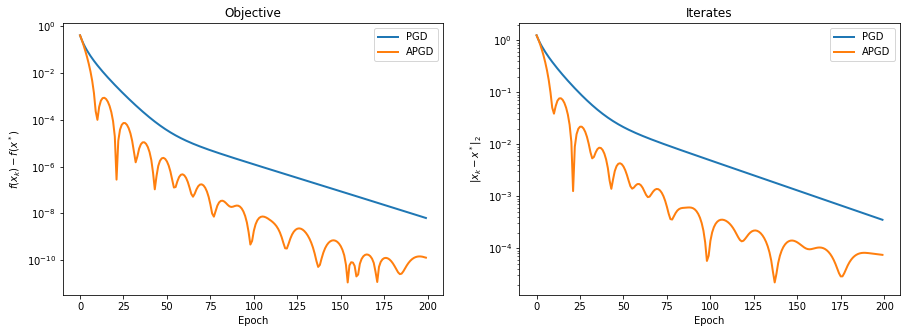

In [29]:
lbda = 0.1

# TODO
x_min = multinomial_lbfgs_l2(X, Y, lbda)
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, (X, Y, lbda))

grad_args = (X, Y)
prox_args = (step, lbda, K)
monitor_apgd_l2.run(x_init, grad_f, prox_l2, n_iter, step, grad_args, prox_args)
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

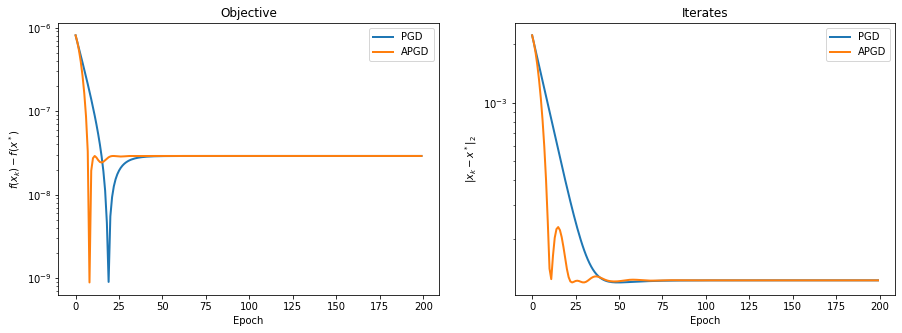

In [30]:
lbda = 1.

# TODO
x_min = minimize(pobj_l1, x_init, args=(X, Y, lbda), method='SLSQP', 
                 options={'ftol':1e-30}).x
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min, (X, Y, lbda))

grad_args = (X, Y)
prox_args = (step, lbda, K)
monitor_apgd_l1.run(x_init, grad_f, prox_l1, n_iter, step, grad_args, prox_args)
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

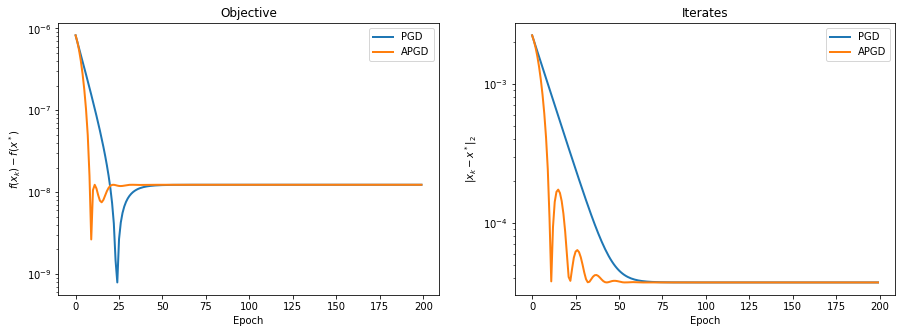

In [31]:
lbda = 1.

# TODO
x_min = minimize(pobj_l21, x_init, args=(X, Y, lbda), method='SLSQP', 
                 options={'ftol':1e-20}).x
monitor_apgd_l21 = monitor(apgd, pobj_l21, x_min, (X, Y, lbda))

grad_args = (X, Y)
prox_args = (step, lbda, K)
monitor_apgd_l21.run(x_init, grad_f, prox_l21, n_iter, step, grad_args, prox_args)
# END TODO

monitors = [monitor_pgd_l21, monitor_apgd_l21]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

# Part 2: Application

You will now apply your solver to the `digits` dataset from scikit-learn

Let's first inspect the dataset:

In [32]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
X_digits.shape, y_digits.shape, np.unique(y_digits)

((1797, 64), (1797,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

Each row of X is an 8x8 image of digit:

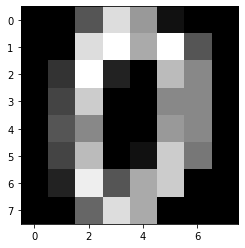

In [33]:
img = X_digits[0].reshape(8, 8)
plt.imshow(img, cmap="gray");

In order to highlight the importance of regularization and especially L1 we are going
to artificially add some random features with pure noise.

In [34]:
X = np.concatenate([X_digits, np.random.randn(len(X_digits), 1000)], axis=1)

Let's do a basic scaling of the features:

In [35]:
from sklearn.preprocessing import scale
X = scale(X)

Now test the functions above with this dataset:

In [36]:
x_init = np.zeros((X.shape[1] + 1) * np.unique(y_digits).size)
Y = OneHotEncoder().fit_transform(y_digits[:, None]).toarray()
print(negloglik(x_init, X=X, Y=Y))
print(grad_negloglik(x_init, X=X, Y=Y).shape)

2.3025850929940463
(10650,)


In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [37]:
from sklearn.base import BaseEstimator, ClassifierMixin


class MultinomialLogistic(BaseEstimator, ClassifierMixin):
    """scikit-learn estimator for the MultinomialLogistic model
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2' | 'l21'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'lbfgs'
        The type of regularization to use.
        'lbfgs' is only supported with penalty='l2'.
        
    Attributes
    ----------
    W_ : ndarray, shape (n_features, n_classes)
        The weights.
    b_ : ndarray, shape (n_classes,)
        The biases / intercepts.
    """
    def __init__(self, lbda=1., penalty='l2', max_iter=2000,
                 solver='lbfgs'):
        self.lbda = lbda
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2', 'l21']
        assert self.solver in ['pgd', 'apgd', 'lbfgs'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target. Must be integers between 0 and n_classes - 1.
        """
        n_classes = int(np.max(y)) + 1
        assert np.all(np.unique(y) == np.arange(n_classes))
        Y = OneHotEncoder().fit_transform(y[:, None]).toarray()
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros((n_features + 1) * n_classes)
        step = n_classes * n_samples / (linalg.norm(X)**2 * (n_classes - 1))

        grad_args = (X, Y)
        prox_args = (step, self.lbda, n_classes)

        if self.solver is 'pgd':
          x = pgd(x_init, grad_negloglik, 
                  eval("prox_"+self.penalty), 
                  self.max_iter, step, grad_args,
                  prox_args)[0]
        elif self.solver is 'apgd':
          x = apgd(x_init, grad_negloglik, 
                   eval("prox_"+self.penalty), 
                   self.max_iter, step, grad_args,
                   prox_args)[0]
        else:
          assert self.penalty is 'l2'
          x = multinomial_lbfgs_l2(X, Y, self.lbda)

        W = x[n_classes:]
        b = x[:n_classes]
        # END TODO
        self.params_ = x
        self.W_ = W
        self.b_ = b
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """Predict proba method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_proba : ndarray, shape (n_samples, n_classes)
            The predicted probabilities.
        """
        return predict_proba(self.params_, X)


for solver in ['pgd', 'apgd', 'lbfgs']:
    clf = MultinomialLogistic(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L2: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L1: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))
    
for solver in ['pgd', 'apgd']:
    clf = MultinomialLogistic(lbda=.01, penalty='l21', max_iter=1000, solver=solver)
    clf.fit(X, y_digits)
    print('Solver with L21: %s   -   Score : %s' % (solver, clf.score(X, y_digits)))

<>:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_59417/188630010.py:56: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.solver is 'pgd':
/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_59417/188630010.py:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.solver is 'apgd':
/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_59417/188630010.py:67: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert self.penalty is 'l2'
/var/folders/zs/9mdddcmn3tq426823wdjcqyr0000gn/T/ipykernel_59417/188630010.py:56: SyntaxWarning: "is" with a literal. Did you mean

KeyboardInterrupt: 

<div class="alert alert-success">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Compare the performance of your model on test data when varying
        the penalty among 
  $\ell_2$, $\ell_1$ and $\ell_{21}$ for a grid of lambda values. Comment on what you see on the curves.
    </li>
    </ul>
</div>

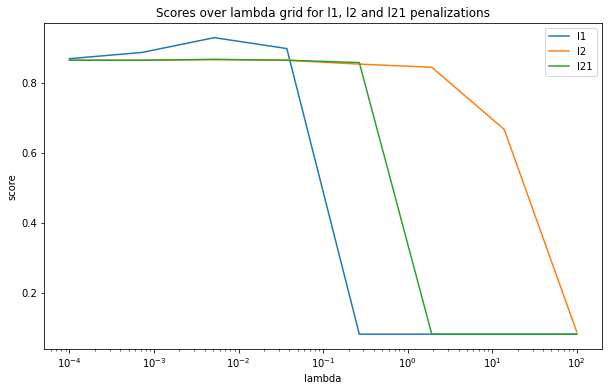

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_digits, random_state=42)
lbda_grid = np.geomspace(1e-4, 1e2, 8)
penal_list = ['l1', 'l2', 'l21']

# TODO
scores = []
for penal in penal_list:
  for l in lbda_grid:
    clf = MultinomialLogistic(lbda=l, penalty=penal, max_iter=300, solver='apgd')
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
scores = np.array(scores).reshape((len(penal_list), -1))

plt.figure(figsize=(10,6))
for i, elem in enumerate(scores):
  plt.semilogx(lbda_grid, elem, label=penal_list[i])
plt.title("Scores over lambda grid for l1, l2 and l21 penalizations")
plt.xlabel('lambda')
plt.ylabel('score')
plt.legend()
plt.show()
# END TODO

INSERT YOUR ANSWER HERE

# Part 3 (bonus): Implement block-coordinate descent

<div class="alert alert-success">
    <b>QUESTION 14:</b>
    <ul>
    <li>
        Implement a proximal block-coordinate descent algorithm and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

**HINT:** The easiest way is to use block udpates where you update iteratively for each pass over the data first `b` and then each row of `W`.

In [ ]:
### TODO
def pbcd(x_init, grad, prox, step=1., n_iter=100, grad_args=(), prox_args=()):
  x = x_init.copy().reshape((P,K))
  n_features, n_classes = (P,K)

  for t in range(n_iter):
    for j in range(n_features):
      
      old_x_j = x[j].copy()
      x[j] = prox(x[j] - step * grad( , *grad_args), *prox_args)

### END TODO